3/3 [==============================] - 0s 2ms/step
   missing_percentage       ml_mse     ml_r2       dl_mse     dl_r2  \
0                 0.1  3314.944420  0.374321  3247.437291  0.387062   
1                 0.3  3659.450825  0.309297  3704.092684  0.300871   
2                 0.5  3883.003037  0.267102  3890.670421  0.265655   
3                 0.7  4075.191855  0.230828  4599.037998  0.131954   
4                 0.9  5259.372172  0.007319  4937.980664  0.067981   

       pca_mse    pca_r2                                 feature_importance  
0  3096.137378  0.415619  [4.583379772076369, 2.2411101566871596, 27.985...  
1  3591.473191  0.322127  [2.5133216848278543, 2.246683050214305, 23.746...  
2  3497.021455  0.339954  [3.486772806612395, 3.0618448828252443, 13.028...  
3  4128.865811  0.220697  [5.3092790679707615, 2.3332340576593285, 11.04...  
4  4241.627656  0.199414  [3.165033975543144, 1.3249288697003496, 2.7895...  


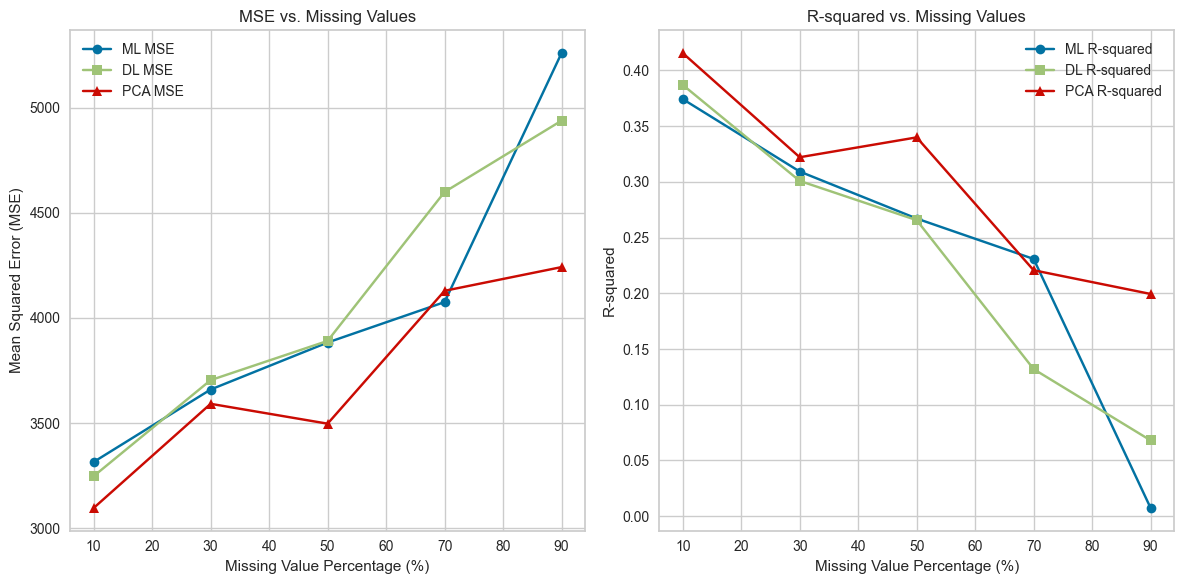

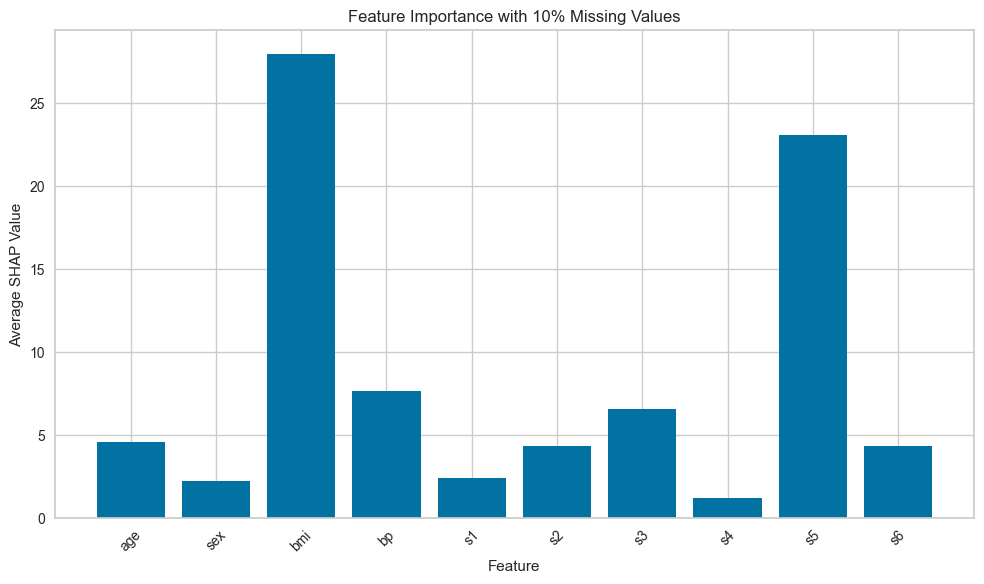

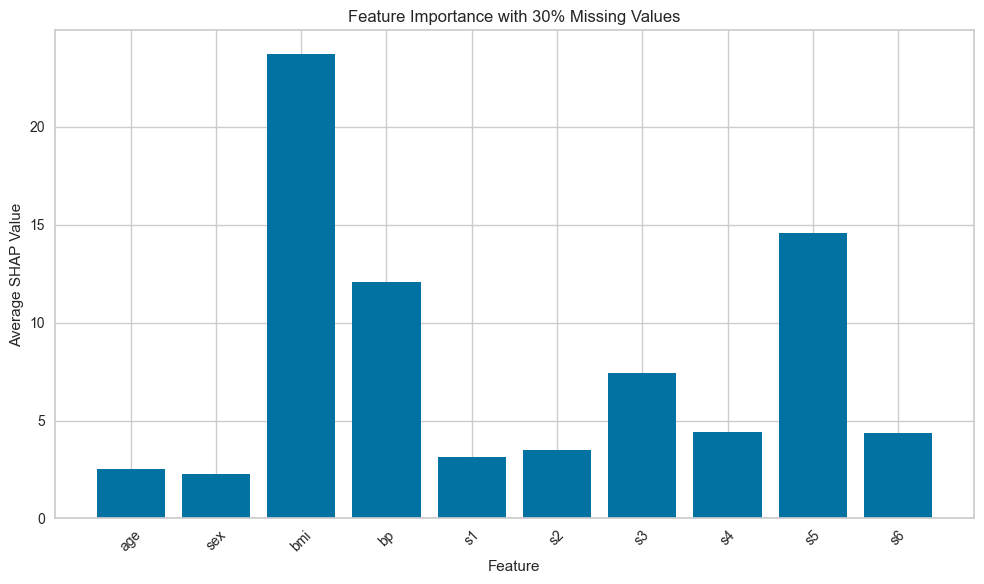

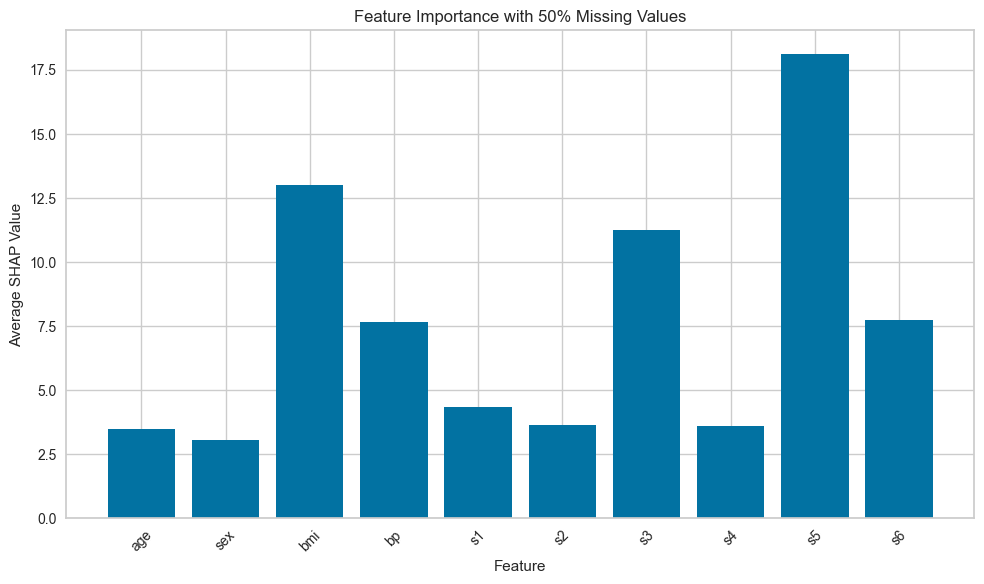

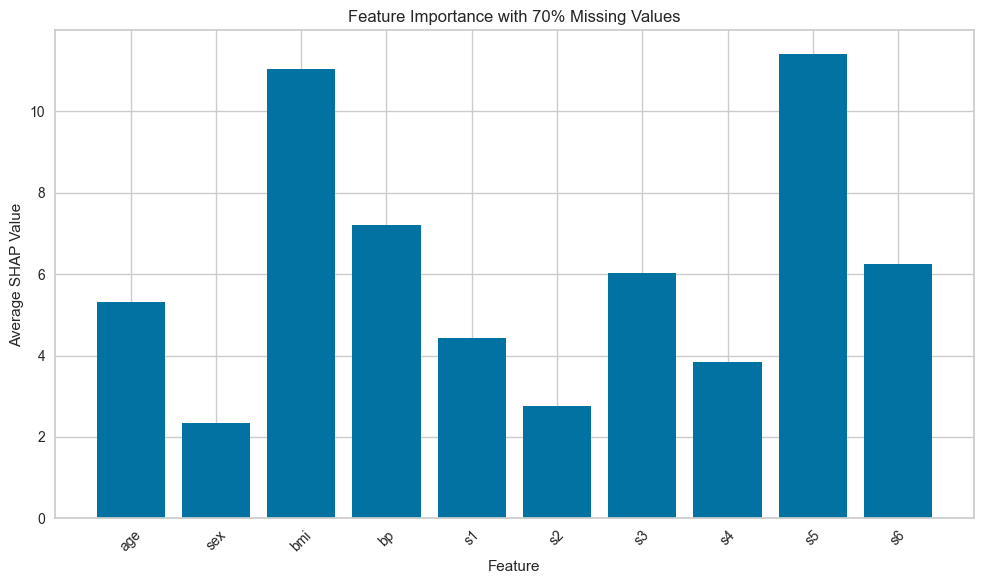

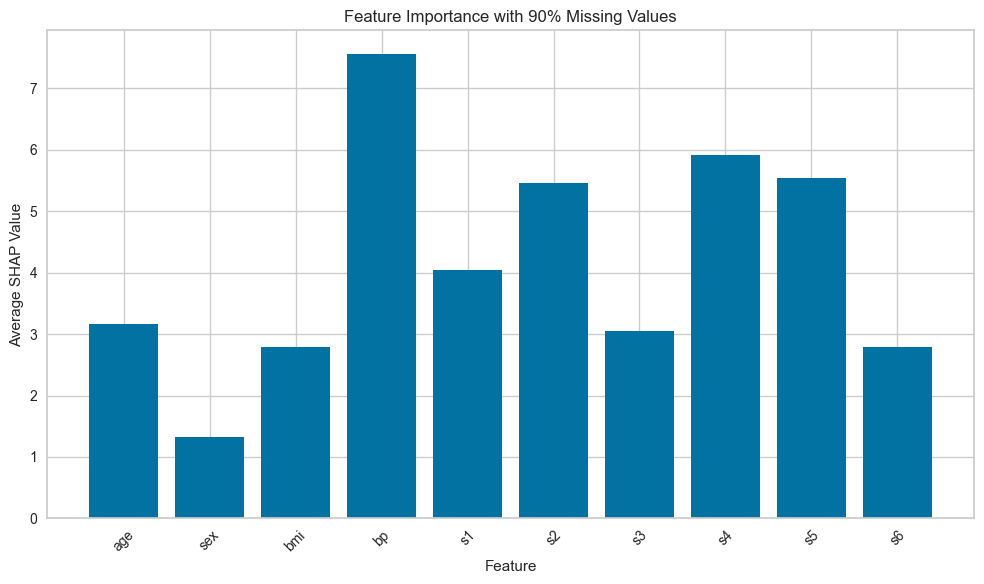

In [34]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import shap
import matplotlib.pyplot as plt

# Load diabetes dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target
feature_names = diabetes.feature_names

# Function to introduce missing values
def introduce_missing_values(X, missing_percentage):
    X_missing = X.copy()
    n_missing_samples = int(np.floor(missing_percentage * X.size))
    missing_samples = np.random.choice(X.size, n_missing_samples, replace=False)
    X_missing.flat[missing_samples] = np.nan
    return X_missing

# Introduce missing values
missing_percentages = [0.1, 0.3, 0.5, 0.7, 0.9]
results = []

for missing_percentage in missing_percentages:
    X_missing = introduce_missing_values(X, missing_percentage)
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X_missing)
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)
    
    # Train and evaluate machine learning model
    ml_model = RandomForestRegressor()
    ml_model.fit(X_train, y_train)
    y_pred_ml = ml_model.predict(X_test)
    ml_mse = mean_squared_error(y_test, y_pred_ml)
    ml_r2 = r2_score(y_test, y_pred_ml)
    
    # Train and evaluate deep learning model
    dl_model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    dl_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    dl_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    y_pred_dl = dl_model.predict(X_test)
    dl_mse = mean_squared_error(y_test, y_pred_dl)
    dl_r2 = r2_score(y_test, y_pred_dl)
    
    # Train and evaluate PCA model
    pca = PCA(n_components=min(X_train.shape[1], X_train.shape[0]))
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    pca_model = LinearRegression()
    pca_model.fit(X_train_pca, y_train)
    y_pred_pca = pca_model.predict(X_test_pca)
    pca_mse = mean_squared_error(y_test, y_pred_pca)
    pca_r2 = r2_score(y_test, y_pred_pca)
    
    # Calculate SHAP values for feature importance
    explainer = shap.TreeExplainer(ml_model, check_additivity=False)
    shap_values = explainer.shap_values(X_train)
    feature_importance = np.abs(shap_values).mean(axis=0)
    
    # Store results
    results.append({
        'missing_percentage': missing_percentage,
        'ml_mse': ml_mse,
        'ml_r2': ml_r2,
        'dl_mse': dl_mse,
        'dl_r2': dl_r2,
        'pca_mse': pca_mse,
        'pca_r2': pca_r2,
        'feature_importance': feature_importance
    })

# Display results
results_df = pd.DataFrame(results)
print(results_df)

# Plot the changes in MSE with varying missing value percentages
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(results_df['missing_percentage'] * 100, results_df['ml_mse'], marker='o', label='ML MSE')
plt.plot(results_df['missing_percentage'] * 100, results_df['dl_mse'], marker='s', label='DL MSE')
plt.plot(results_df['missing_percentage'] * 100, results_df['pca_mse'], marker='^', label='PCA MSE')
plt.xlabel('Missing Value Percentage (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs. Missing Values')
plt.legend()
plt.grid(True)

# Plot the changes in R-squared with varying missing value percentages
plt.subplot(1, 2, 2)
plt.plot(results_df['missing_percentage'] * 100, results_df['ml_r2'], marker='o', label='ML R-squared')
plt.plot(results_df['missing_percentage'] * 100, results_df['dl_r2'], marker='s', label='DL R-squared')
plt.plot(results_df['missing_percentage'] * 100, results_df['pca_r2'], marker='^', label='PCA R-squared')
plt.xlabel('Missing Value Percentage (%)')
plt.ylabel('R-squared')
plt.title('R-squared vs. Missing Values')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot SHAP feature importance with feature names
for i, row in results_df.iterrows():
    shap_values = row['feature_importance']
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(shap_values)), shap_values)
    plt.xticks(range(len(feature_names)), feature_names, rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Average SHAP Value')
    plt.title(f'Feature Importance with {int(row["missing_percentage"]*100)}% Missing Values')
    plt.tight_layout()
    plt.show()


In [2]:
from sklearn.datasets import load_diabetes
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from pycaret.regression import setup, compare_models, pull, get_config

# Load diabetes dataset
diabetes = load_diabetes()
X, y = diabetes.data, diabetes.target

# Function to introduce missing values
def introduce_missing_values(data, missing_percentage):
    data_missing = data.copy()
    n_missing_samples = int(np.floor(missing_percentage * data_missing.size))
    missing_samples = np.random.choice(data_missing.size, n_missing_samples, replace=False)
    for sample in missing_samples:
        row = sample // data_missing.shape[1]
        col = sample % data_missing.shape[1]
        data_missing.iat[row, col] = np.nan
    return data_missing

# Introduce missing values
missing_percentages = [0.1, 0.2, 0.3, 0.4, 0.5]
results = []
data = pd.DataFrame(data=np.c_[X, y], columns=[*diabetes.feature_names, 'target'])

from pycaret.regression import setup, compare_models, pull, get_config

for missing_percentage in missing_percentages:
    data_missing = introduce_missing_values(data, missing_percentage)
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    data_imputed = pd.DataFrame(imputer.fit_transform(data_missing), columns=data.columns)
    
    # Setup PyCaret
    exp = setup(data=data_imputed)
    
    # Compare models and get top 10 for machine learning
    best_ml_models = compare_models(n_select=10)
    best_ml_models_results = pull()
    best_ml_models_results['missing_percentage'] = missing_percentage
    best_ml_models_results['model_type'] = 'machine learning'
    results.append(best_ml_models_results)
    


,Description,Value
0,Session id,838
1,Target,target
2,Target type,Regression
3,Original data shape,"(442, 11)"
4,Transformed data shape,"(442, 11)"
5,Transformed train set shape,"(309, 11)"
6,Transformed test set shape,"(133, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,46.4024,3139.1122,55.5996,0.3889,0.4197,0.4069,0.0100
lr,Linear Regression,46.3084,3158.5391,55.6953,0.3847,0.4193,0.4035,0.7650
lar,Least Angle Regression,46.3084,3158.5392,55.6953,0.3847,0.4193,0.4035,0.0100
huber,Huber Regressor,46.5527,3202.8932,56.0740,0.3760,0.4196,0.4026,0.0150
par,Passive Aggressive Regressor,48.7570,3417.4510,58.2468,0.3448,0.4315,0.4180,0.0090
et,Extra Trees Regressor,48.4403,3397.3144,58.0961,0.3426,0.4372,0.4254,0.0400
rf,Random Forest Regressor,49.0115,3489.9936,58.9026,0.3233,0.4417,0.4303,0.0550
ridge,Ridge Regression,50.3050,3591.3777,59.7844,0.3112,0.4556,0.4617,0.0090
ada,AdaBoost Regressor,49.6031,3585.5866,59.5822,0.3040,0.4468,0.4405,0.0200
omp,Orthogonal Matching Pursuit,49.6734,3735.1573,60.7470,0.2878,0.4520,0.4395,0.0090


,Description,Value
0,Session id,4242
1,Target,target
2,Target type,Regression
3,Original data shape,"(442, 11)"
4,Transformed data shape,"(442, 11)"
5,Transformed train set shape,"(309, 11)"
6,Transformed test set shape,"(133, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,44.9277,3157.3304,55.8921,0.3416,0.4106,0.3891,0.0080
huber,Huber Regressor,45.0521,3169.5595,55.9753,0.3400,0.4091,0.3840,0.0110
lr,Linear Regression,44.9952,3173.3548,56.0312,0.3381,0.4103,0.3872,0.0090
lar,Least Angle Regression,44.9952,3173.3545,56.0312,0.3381,0.4103,0.3872,0.0090
et,Extra Trees Regressor,46.9293,3340.6050,57.3237,0.3012,0.4146,0.3996,0.0400
ada,AdaBoost Regressor,48.7216,3406.6429,58.1058,0.2898,0.4190,0.4153,0.0220
par,Passive Aggressive Regressor,47.6504,3555.5102,59.2163,0.2642,0.4310,0.4149,0.0080
rf,Random Forest Regressor,47.8176,3542.1157,58.8721,0.2607,0.4225,0.4047,0.0570
ridge,Ridge Regression,48.1047,3550.7052,59.4002,0.2589,0.4381,0.4299,0.0110
gbr,Gradient Boosting Regressor,49.1652,3618.5642,59.8515,0.2405,0.4321,0.4172,0.0220


,Description,Value
0,Session id,4205
1,Target,target
2,Target type,Regression
3,Original data shape,"(442, 11)"
4,Transformed data shape,"(442, 11)"
5,Transformed train set shape,"(309, 11)"
6,Transformed test set shape,"(133, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,43.4637,2925.6407,53.6536,0.1968,0.4064,0.3880,0.0120
lr,Linear Regression,43.7531,2948.8668,53.8993,0.1869,0.4068,0.3862,0.0080
lar,Least Angle Regression,43.7531,2948.8672,53.8993,0.1869,0.4068,0.3862,0.0120
huber,Huber Regressor,43.3681,3013.3871,54.4743,0.1735,0.4056,0.3778,0.0110
et,Extra Trees Regressor,43.7520,2997.9710,54.4419,0.1603,0.4125,0.3913,0.0370
ridge,Ridge Regression,42.7671,3140.0661,55.3977,0.1550,0.4201,0.3987,0.0110
rf,Random Forest Regressor,45.5264,3120.7673,55.4496,0.1381,0.4162,0.4011,0.0510
ada,AdaBoost Regressor,47.0274,3163.5560,55.7040,0.1317,0.4115,0.4058,0.0200
lightgbm,Light Gradient Boosting Machine,45.1867,3133.8245,55.5714,0.1311,0.4134,0.3924,0.0590
omp,Orthogonal Matching Pursuit,44.5801,3341.3283,57.0264,0.1067,0.4274,0.4057,0.0150


,Description,Value
0,Session id,8093
1,Target,target
2,Target type,Regression
3,Original data shape,"(442, 11)"
4,Transformed data shape,"(442, 11)"
5,Transformed train set shape,"(309, 11)"
6,Transformed test set shape,"(133, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,41.9142,2862.9354,53.3539,0.1508,0.4168,0.3900,0.0080
lr,Linear Regression,42.3633,2890.1534,53.6197,0.1392,0.4192,0.3924,0.0090
lar,Least Angle Regression,42.3633,2890.1532,53.6197,0.1392,0.4192,0.3924,0.0080
huber,Huber Regressor,41.8605,2916.0811,53.8260,0.1367,0.4177,0.3887,0.0110
ada,AdaBoost Regressor,43.4540,2910.2084,53.8379,0.1302,0.4155,0.3963,0.0230
ridge,Ridge Regression,40.7368,3039.8215,54.8513,0.1137,0.4235,0.3872,0.0080
gbr,Gradient Boosting Regressor,42.5441,2969.2841,54.2934,0.1083,0.4124,0.3800,0.0200
rf,Random Forest Regressor,43.2730,2994.8261,54.5826,0.1075,0.4182,0.3930,0.0550
lightgbm,Light Gradient Boosting Machine,45.2506,3104.5213,55.4994,0.0815,0.4248,0.4046,0.0880
et,Extra Trees Regressor,43.9562,3078.2726,55.3307,0.0784,0.4210,0.3952,0.0440


,Description,Value
0,Session id,4303
1,Target,target
2,Target type,Regression
3,Original data shape,"(442, 11)"
4,Transformed data shape,"(442, 11)"
5,Transformed train set shape,"(309, 11)"
6,Transformed test set shape,"(133, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,40.1090,2677.6487,51.6159,0.1969,0.3929,0.3557,0.0120
lr,Linear Regression,40.7005,2696.8713,51.8111,0.1890,0.3937,0.3572,0.0100
lar,Least Angle Regression,40.7005,2696.8714,51.8111,0.1890,0.3937,0.3572,0.0090
huber,Huber Regressor,39.6683,2763.4615,52.4026,0.1761,0.3980,0.3583,0.0110
rf,Random Forest Regressor,41.7659,2814.0414,52.9027,0.1510,0.3962,0.3607,0.0580
et,Extra Trees Regressor,42.1814,2844.7482,53.0905,0.1463,0.3984,0.3629,0.0450
ada,AdaBoost Regressor,42.5747,2838.9576,53.1836,0.1375,0.3933,0.3582,0.0200
lightgbm,Light Gradient Boosting Machine,42.7402,2896.4415,53.7541,0.1220,0.4029,0.3691,0.0680
ridge,Ridge Regression,37.9239,2959.7759,54.1957,0.1213,0.4074,0.3534,0.0090
omp,Orthogonal Matching Pursuit,39.0145,2965.1548,54.2014,0.1190,0.4107,0.3610,0.0090


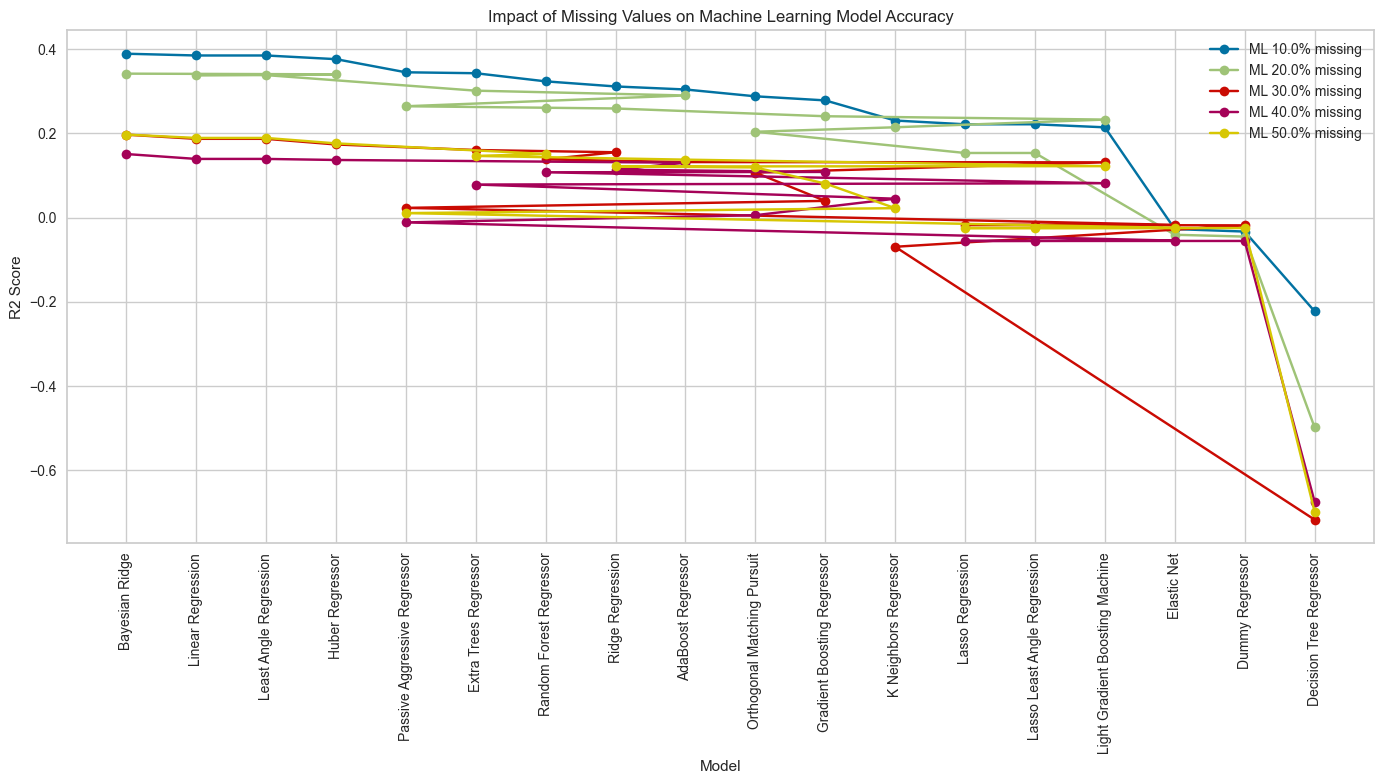

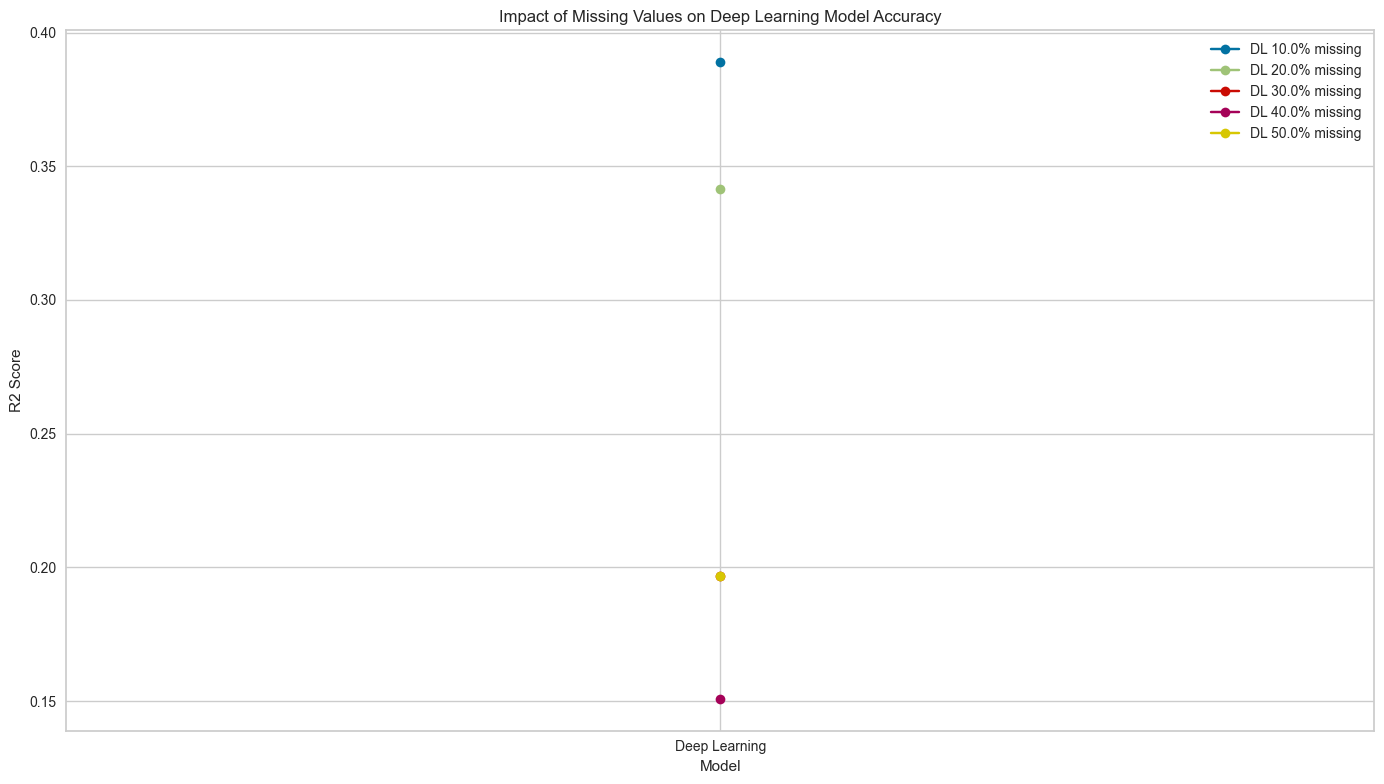

In [3]:
results_model = pd.concat(results, ignore_index=True)
import matplotlib.pyplot as plt

# Plot the changes in R2 with varying missing value percentages for machine learning models
plt.figure(figsize=(14, 8))
for missing_percentage in missing_percentages:
    subset = results_model[results_model['missing_percentage'] == missing_percentage]
    plt.plot(subset['Model'], subset['R2'], marker='o', label=f'ML {missing_percentage*100}% missing')

plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Impact of Missing Values on Machine Learning Model Accuracy')
plt.legend(loc='best', fontsize='small')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the changes in R2 with varying missing value percentages for deep learning models
plt.figure(figsize=(14, 8))
for missing_percentage in missing_percentages:
    subset = results_model[results_model['missing_percentage'] == missing_percentage]
    plt.plot(['Deep Learning'], [subset['R2'].values[0]], marker='o', label=f'DL {missing_percentage*100}% missing')

plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Impact of Missing Values on Deep Learning Model Accuracy')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# check model fairness
lr_fairness = check_fairness(lr, sensitive_features = ['sex', 'race'])

In [73]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from pycaret.classification import *

# Function to introduce missing values
def introduce_missing_values(data, missing_percentage, exclude_columns=None):
    data_missing = data.copy()
    if exclude_columns:
        data_missing = data_missing.drop(columns=exclude_columns)
    n_missing_samples = int(np.floor(missing_percentage * data_missing.size))
    missing_samples = np.random.choice(data_missing.size, n_missing_samples, replace=False)
    for sample in missing_samples:
        row = sample // data_missing.shape[1]
        col = sample % data_missing.shape[1]
        data_missing.iat[row, col] = np.nan
    return data_missing

# Load dataset
from pycaret.datasets import get_data
diabetes = get_data('diabetes')

# Introduce missing values, excluding the target variable
missing_percentages = [0.1, 0.3, 0.5]

# Dictionary to store evaluation results
evaluation_results = {}

for missing_percentage in missing_percentages:
    print('missing_percentage>>>>>',missing_percentage)
    data_missing = introduce_missing_values(diabetes, missing_percentage, exclude_columns=None)  # Remove exclude_columns parameter

    # Impute missing values for all columns, including the target variable
    imputer = SimpleImputer(strategy='mean')
    data_imputed_values = imputer.fit_transform(data_missing)
    data_imputed = pd.DataFrame(data_imputed_values, columns=data_missing.columns)

    # Convert target variable to binary format (0 or 1)
    data_imputed['Class variable'] = data_imputed['Class variable'].astype(int)

    # Ensure target variable is in the feature dataset
    features = data_imputed.drop(columns=['Class variable'])

    # Initialize setup with missing values
    clf_missing = setup(data=data_imputed, target='Class variable')

    # Create model
    lr_missing = create_model('lr')

    # Evaluate model
    evaluate_model(lr_missing)
    
    # interpret_model(lr_missing, plot = 'pdp',feature = 'Age (years)')
    
    # # interpret model
    # interpret_model(lr_missing, plot = 'msa')


,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


missing_percentage>>>>> 0.1


,Description,Value
0,Session id,5829
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8148,0.8203,0.5882,0.7692,0.6667,0.5416,0.5509
1,0.6111,0.6677,0.3529,0.3750,0.3636,0.0840,0.0841
2,0.7037,0.7758,0.4706,0.5333,0.5000,0.2906,0.2918
3,0.7963,0.7838,0.4706,0.8000,0.5926,0.4687,0.4980
4,0.7407,0.8076,0.4118,0.6364,0.5000,0.3357,0.3502
5,0.7778,0.8394,0.4706,0.7273,0.5714,0.4306,0.4492
6,0.7963,0.7854,0.5882,0.7143,0.6452,0.5042,0.5088
7,0.8868,0.9020,0.6250,1.0000,0.7692,0.6994,0.7333
8,0.7358,0.7483,0.3750,0.6000,0.4615,0.2987,0.3132


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

missing_percentage>>>>> 0.3


,Description,Value
0,Session id,3100
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7963,0.7617,0.2308,0.7500,0.3529,0.2703,0.3369
1,0.7407,0.7205,0.0769,0.3333,0.1250,0.0382,0.0525
2,0.7407,0.6642,0.3077,0.4444,0.3636,0.2075,0.2131
3,0.7593,0.7486,0.1538,0.5000,0.2353,0.1376,0.1715
4,0.7778,0.8143,0.2308,0.6000,0.3333,0.2304,0.2684
5,0.7222,0.7674,0.0769,0.2500,0.1176,0.0049,0.0061
6,0.7593,0.6848,0.3077,0.5000,0.3810,0.2419,0.2529
7,0.7925,0.7500,0.4167,0.5556,0.4762,0.3501,0.3557
8,0.7736,0.7096,0.2308,0.6000,0.3333,0.2282,0.2661


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

missing_percentage>>>>> 0.5


,Description,Value
0,Session id,1853
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8148,0.7926,0.0000,0.0000,0.0000,-0.0345,-0.0614
1,0.8704,0.7309,0.2222,1.0000,0.3636,0.3226,0.4385
2,0.7963,0.6074,0.1111,0.2500,0.1538,0.0571,0.0632
3,0.8333,0.6864,0.1111,0.5000,0.1818,0.1290,0.1754
4,0.8333,0.7481,0.1111,0.5000,0.1818,0.1290,0.1754
5,0.8148,0.6556,0.0000,0.0000,0.0000,-0.0345,-0.0614
6,0.8519,0.6963,0.2222,0.6667,0.3333,0.2727,0.3254
7,0.8302,0.7222,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8302,0.7626,0.0000,0.0000,0.0000,0.0000,0.0000


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8312,0.7520,0.0952,0.8000,0.1702,0.1368,0.2384


Found 74 subgroups. Evaluation may be slow
Found 74 subgroups. Evaluation may be slow


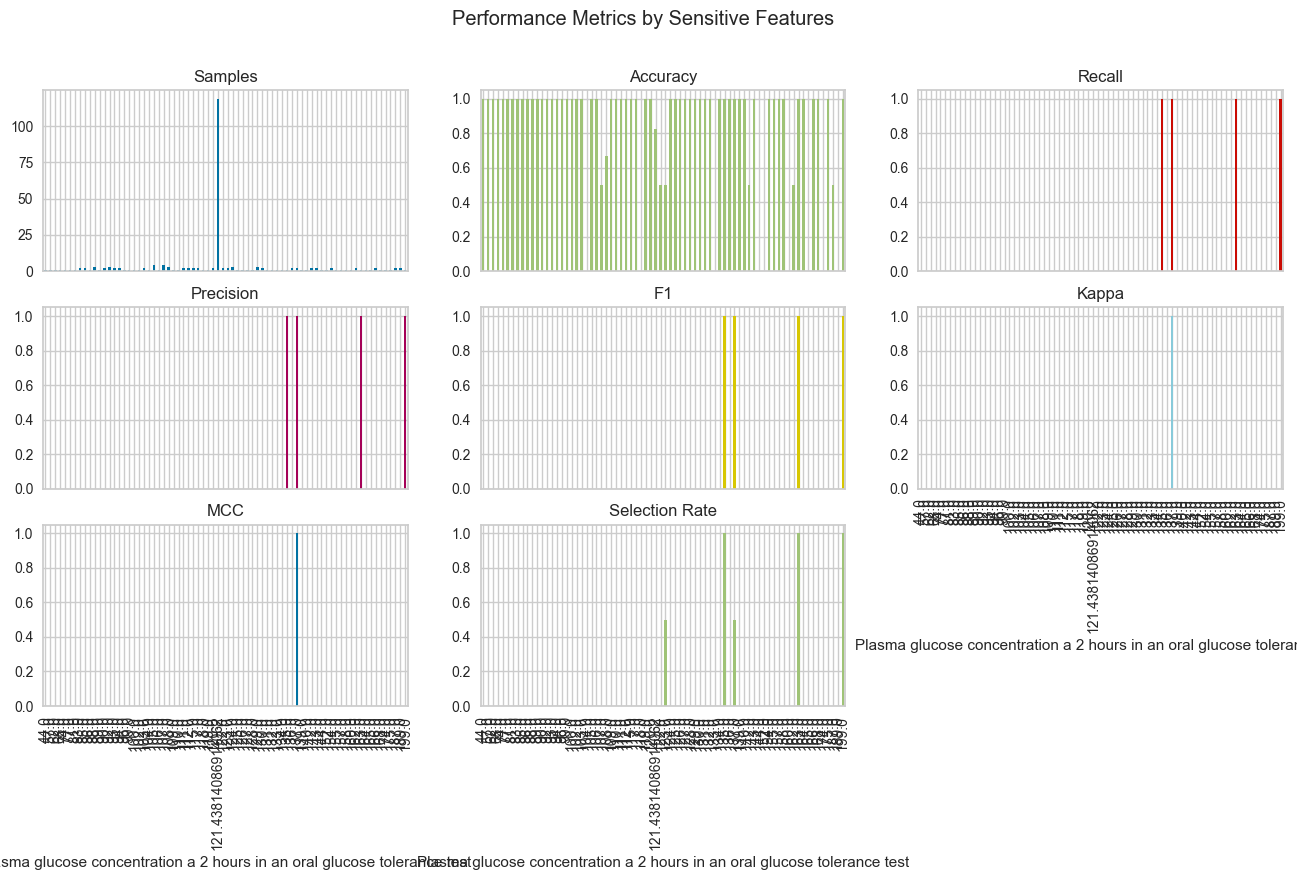

In [72]:
lr_fairness = check_fairness(lr_missing, sensitive_features = ['Plasma glucose concentration a 2 hours in an oral glucose tolerance test'])

In [65]:
import pandas as pd
from sklearn.datasets import load_diabetes

# Load the diabetes dataset from sklearn
diabetes = load_diabetes()
df = pd.DataFrame(data=diabetes.data, columns=diabetes.feature_names)

# For demonstration, let's duplicate a row intentionally to test the logic
df = df.append(df.iloc[0], ignore_index=True)
df = df.append(df.iloc[1], ignore_index=True)

# Find rows that are exactly duplicated
duplicate_rows = df[df.duplicated(keep=False)]
print("Duplicate Rows:")
print(duplicate_rows)

# Group by all columns and count the occurrences
counts = df.groupby(list(df.columns)).size().reset_index(name='counts')

# Filter rows that have exactly two occurrences
exactly_two = counts[counts['counts'] >= 2]
print("\nRows with exactly two occurrences:")
print(exactly_two)


Duplicate Rows:
          age       sex       bmi        bp        s1        s2        s3  \
0    0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1   -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
442  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
443 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   

           s4        s5        s6  
0   -0.002592  0.019907 -0.017646  
1   -0.039493 -0.068332 -0.092204  
442 -0.002592  0.019907 -0.017646  
443 -0.039493 -0.068332 -0.092204  

Rows with exactly two occurrences:
          age       sex       bmi        bp        s1        s2        s3  \
191 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
338  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   

           s4        s5        s6  counts  
191 -0.039493 -0.068332 -0.092204       2  
338 -0.002592  0.019907 -0.017646       2  
